In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Compare model run time series

In [2]:
file = '../../caesar-explore/sithas/results_0/Sithas_v6_50_100days.dat'
sithas_0 = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Qs1', 'Qs2', 'Qs3', 'Qs4'])

In [3]:
file = '../../caesar-explore/sithas/results_1/Sithas_v6_50_100days.dat'
sithas_1 = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Qs1', 'Qs2', 'Qs3', 'Qs4'])

In [4]:
file = '../../caesar-explore/sithas/results_2/Sithas_v6_50_100days.dat'
sithas_2 = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Qs1', 'Qs2', 'Qs3', 'Qs4'])

In [5]:
file = '../../caesar-explore/sithas/results/Sithas_v6_50_100days.dat'
sithas_3 = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Qs1', 'Qs2', 'Qs3', 'Qs4'])

<Figure size 1080x1080 with 0 Axes>

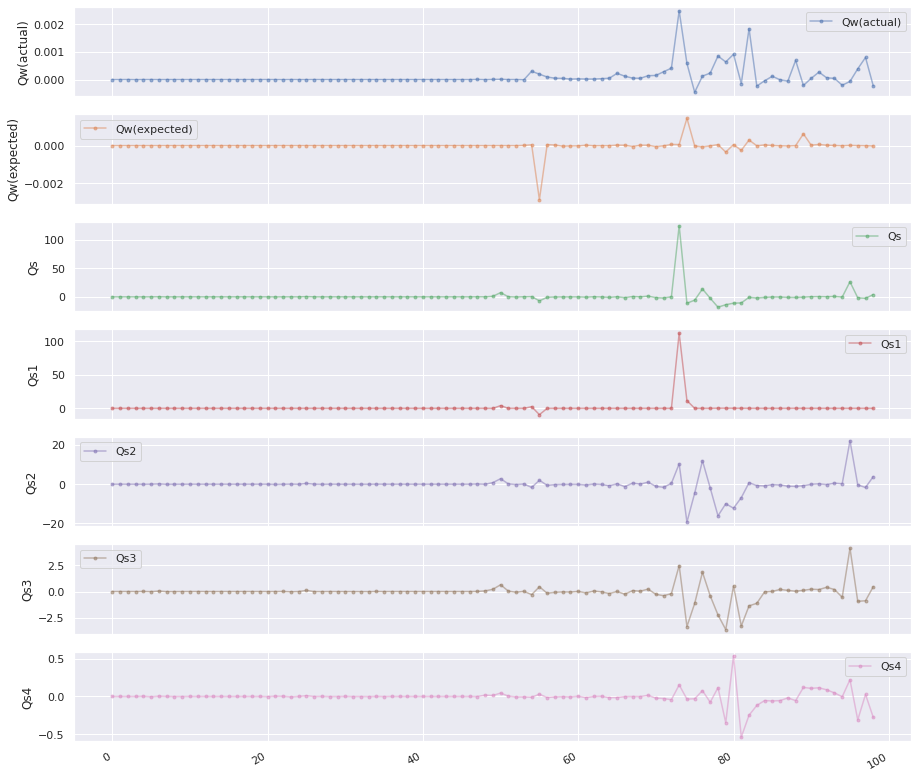

In [9]:
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Qw(actual)', 'Qw(expected)', 'Qs', 'Qs1', 'Qs2', 'Qs3', 'Qs4']
axes = (sithas_0[cols_plot]-sithas_2[cols_plot]).plot(marker='.', alpha=0.5, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_plot[i])
    i += 1
plt.savefig('chalkio_first97days.png')
plt.show()

In [7]:
diff = sithas_0['Qs']-sithas_1['Qs']
eps = np.linalg.norm(diff, np.Inf)

In [8]:
print('|q1-q2||/median(q1) = {} %'.format(100 * eps / np.median(sithas_0['Qs'])))

|q1-q2||/median(q1) = 0.025723354680190907 %
